In [1]:
import ollama
from tqdm import tqdm
import time
import numpy as np

def get_embedding_with_retry(model, prompt, max_retries=5, initial_delay=1):
    retries = 0
    delay = initial_delay
    prefix = "clustering : "
    while retries < max_retries:
        try:
            response = ollama.embeddings(model=model, prompt=prefix + prompt)
            return response["embedding"]
        except ollama.ResponseError as e:
            retries += 1
            print(f"Failed to get embedding. Attempt {retries}/{max_retries}. Error: {e}")
            if retries >= max_retries:
                print(f"Max retries reached for sentence: {prompt}.")
                raise e
            time.sleep(delay)
            delay *= 2  # Exponential backoff

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def load_text_file(file_path):
    """
    Load text from a file.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def split_text_into_words(text):
    """
    Split the text into a list of words.
    """
    return text.split()

def join_words_into_text(words):
    """
    Join a list of words into a text string.
    """
    return ' '.join(words)

def iterative_chunk(words, max_length, overlap):
    # Check if overlap is bigger than max_length
    if overlap >= max_length:
        return [float('inf')], float('inf')

    chunks = []
    start = 0
    while start < len(words):
        end = min(start + max_length, len(words))
        chunk = words[start:end]
        chunks.append(join_words_into_text(chunk))
        start += max_length - overlap
    avg_chunk_length = np.mean([len(split_text_into_words(chunk)) for chunk in chunks])
    return chunks, avg_chunk_length

file_path = 'hostory_book_230p.txt'  # Your text file
max_chunk_lengths = np.arange(100, 8192, 50)  # Maximum chunk size in words
overlap_lengths = np.arange(0, 500, 25)  # Overlap length in words

# Load the text from the file
text = load_text_file(file_path)

# Split the text into words
words = split_text_into_words(text)

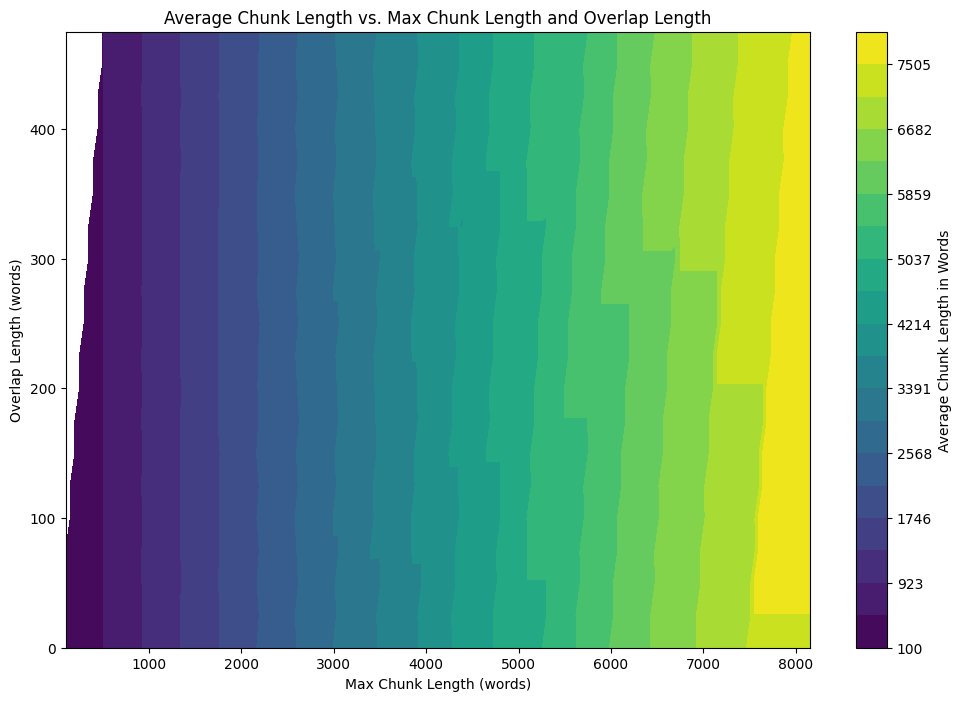

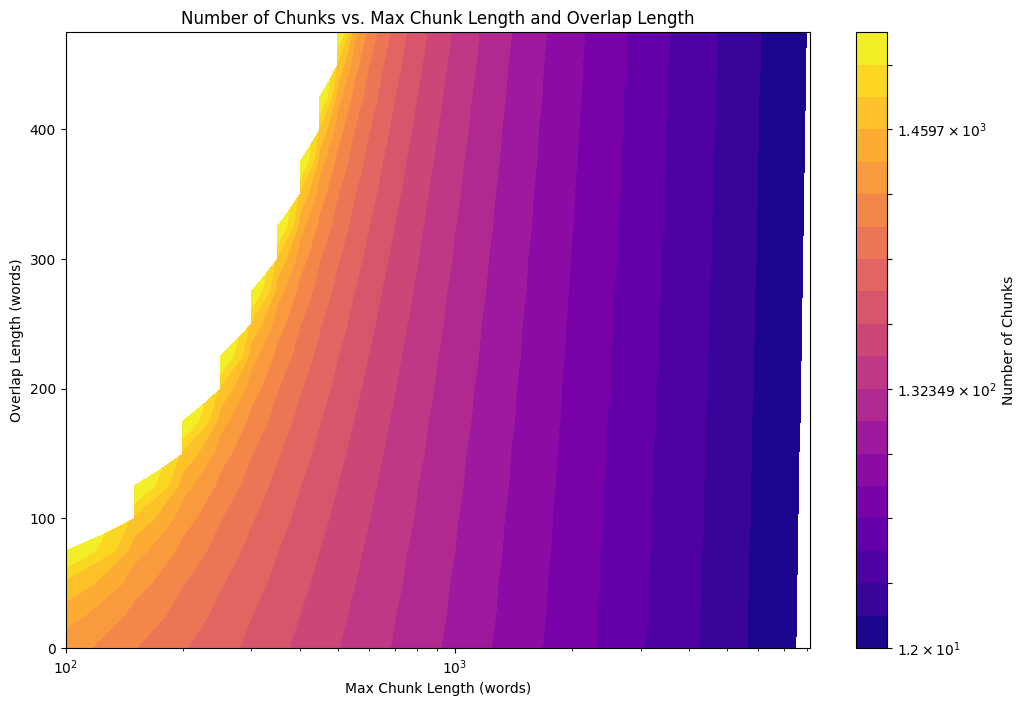

In [3]:


avg_chunk_lengths = []
num_chunks_list = []

for max_chunk_length in max_chunk_lengths:
    avg_chunks_for_current_length = []
    num_chunks_for_current_length = []
    for overlap_length in overlap_lengths:
        chunks, avg_chunk_length = iterative_chunk(words, max_chunk_length, overlap_length)
        if chunks == [float('inf')]:
            avg_chunk_length = float('inf')
            num_chunks = float('inf')
        else:
            num_chunks = len(chunks)
        avg_chunks_for_current_length.append(avg_chunk_length)
        num_chunks_for_current_length.append(num_chunks)
    avg_chunk_lengths.append(avg_chunks_for_current_length)
    num_chunks_list.append(num_chunks_for_current_length)

# Convert the results to a NumPy array for easy handling in the plot
avg_chunk_lengths = np.array(avg_chunk_lengths)
num_chunks_list = np.array(num_chunks_list)

# Create a meshgrid for plotting
X, Y = np.meshgrid(max_chunk_lengths, overlap_lengths)

# Transpose avg_chunk_lengths and num_chunks_list to match X and Y dimensions
Z_avg = avg_chunk_lengths.T
Z_num = num_chunks_list.T

# Plotting average chunk length
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, Z_avg, levels=np.linspace(np.nanmin(Z_avg[np.isfinite(Z_avg)]), np.nanmax(Z_avg[np.isfinite(Z_avg)]), 20), cmap='viridis')
plt.colorbar(label='Average Chunk Length in Words')
plt.title('Average Chunk Length vs. Max Chunk Length and Overlap Length')
plt.xlabel('Max Chunk Length (words)')
plt.ylabel('Overlap Length (words)')
plt.show()

# Plotting number of chunks with logarithmic color scale
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, Z_num, levels=np.logspace(np.log10(np.nanmin(Z_num[np.isfinite(Z_num)])), np.log10(np.nanmax(Z_num[np.isfinite(Z_num)])), 20), 
             cmap='plasma', norm=LogNorm())
plt.colorbar(label='Number of Chunks')
plt.title('Number of Chunks vs. Max Chunk Length and Overlap Length')
plt.xlabel('Max Chunk Length (words)')
plt.xscale("log")
plt.ylabel('Overlap Length (words)')
plt.show()

In [4]:
optimal_length = 1000
optimal_overlap = 200
file_path = 'hostory_book_230p.txt'  # Your text file

chunks , avg_chunk_length = iterative_chunk(words, optimal_length, optimal_overlap)
print(avg_chunk_length)

992.4247787610619


In [5]:
model = "nomic-embed-text"
vdb = []
i = 0 
for  chunk in tqdm(chunks , desc="embedding chunks...") :

    emb = np.array(get_embedding_with_retry(model=model , prompt = chunk )) #embeddings
    if not emb.shape == (0,) : 
        dp = {
            "pos" : i , #chronological position of the chunk 
            "chunk" : chunk , # the chunk itself 
            "embedding" : emb
        }
        i+=1
        vdb.append(dp)


embedding chunks...: 100%|██████████| 113/113 [00:16<00:00,  7.03it/s]


In [6]:
print(vdb[1])

{'pos': 1, 'chunk': 'these represents a combat of reindeer; another a mammoth with woolly hide and curved tusks. Doubtless these men were the contemporaries of the mammoth and the reindeer. They were, like the Esquimaux of our day, a race of hunters and fishermen, knowing how to work in flint and to kindle fires. POLISHED STONE AGE Lake Dwellings.—In 1854, Lake Zurich being very low on account of the unusual dryness of the summer, dwellers on the shore of the lake found, in the mud, wooden piles which had been much eaten away, also some rude utensils. These were the remains of an ancient village built over the water. Since this time more than 200 similar villages have been found in the lakes of Switzerland. They have been called Lake Villages. The piles on which they rest are trunks of trees, pointed and driven into the lake-bottom to a depth of several yards. Every village required 30,000 to 40,000 of these. A wooden platform was supported by the pile work and on this were built woode

In [7]:
print(set([len(d["embedding"]) for d in vdb ]))

{768}


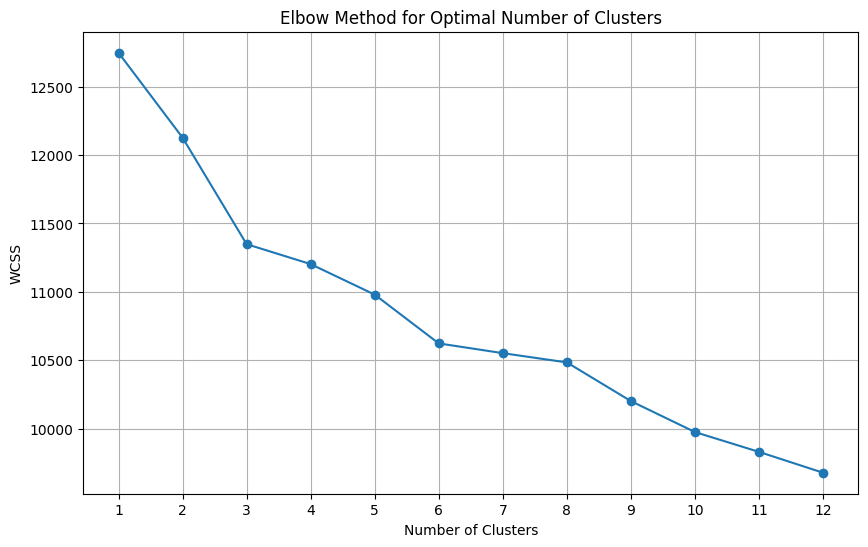

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_wcss(vdb, max_clusters=10):
    """
    Plots the Within-Cluster Sum of Square (WCSS) for different numbers of clusters to determine the optimal number of clusters using the elbow method.

    Parameters:
    - embeddings_dict (dict): Dictionary containing embeddings with keys as identifiers.
    - max_clusters (int): The maximum number of clusters to test. Default is 10.

    Returns:
    - None: Displays a plot of WCSS vs. number of clusters.
    """
    # Convert embeddings to a numpy array
    embeddings = np.array([d["embedding"] for d in vdb ])

    wcss = []

    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    # Plot the WCSS
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True)
    plt.show()
    
plot_wcss(vdb , max_clusters=12)

In [9]:
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
def cluster_chunks_kmeans(vdb, num_clusters):
    """
    Clusters the embeddings using k-means++.

    Parameters:
    - embeddings_dict (dict): Dictionary containing embeddings with keys as identifiers.
    - num_clusters (int): Number of clusters.

    Returns:
    - dict: A dictionary with the same keys but with cluster labels as values.
    """
    # Convert embeddings to a numpy array
    
    embeddings = np.array([d["embedding"] for d in vdb ])

    # Perform k-means++ clustering
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    kmeans.fit(embeddings)
    cluster_labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_
    # Create a dictionary with conversation IDs and their corresponding cluster labels
    clustered_chunks = [
            { 
                'cluster' : cluster_labels[i] , 
                'chunk' : data_point["chunk"] , 
                'embedding' : data_point['embedding'] ,
                'pos' : data_point["pos"]
            } 
            for i , data_point in enumerate(vdb)
    ]

    return clustered_chunks , cluster_centroids 

In [10]:
num_clusters = 8
clustered_chunks , cluster_centroids  = cluster_chunks_kmeans(vdb , num_clusters)

In [11]:
clustered_chunks[0]

{'cluster': 7,
 'chunk': 'History Of Ancient Civilization by Charles Seignobos History Of Ancient Civilization CHAPTER I THE ORIGINS OF CIVILIZATION PREHISTORIC ARCHÆOLOGY Prehistoric Remains.—One often finds buried in the earth, weapons, implements, human skeletons, débris of every kind left by men of whom we have no direct knowledge. These are dug up by the thousand in all the provinces of France, in Switzerland, in England, in all Europe; they are found even in Asia and Africa. It is probable that they exist in all parts of the world. These remains are called prehistoric because they are more ancient than written history. For about fifty years men have been engaged in recovering and studying them. Today most museums have a hall, or at least, some cases filled with these relics. A museum at Saint-German-en-Laye, near Paris, is entirely given up to prehistoric remains. In Denmark is a collection of more than 30,000 objects. Every day adds to the discoveries as excavations are made, ho

In [12]:
import numpy as np 
def find_closest_data_points_to_centroid(clustered_chunks , cluster_centroids , top_k  ) : 
    closest_sentences = {}
    for cluster_index , cluster_centroid in enumerate( cluster_centroids) :
        distances = []
        for data in clustered_chunks : 
            if data["cluster"] == cluster_index : 
                distances.append({
                    "distance" :np.linalg.norm(cluster_centroid - data["embedding"]) , 
                    "chunk" : data["chunk"]
                })
        
        distances = sorted(distances , key=lambda  x : x["distance"])
        closest_sentences[cluster_index] =[ e["chunk"] for e in distances[ : top_k]]
        
    
    return closest_sentences


closest_chunks = find_closest_data_points_to_centroid(clustered_chunks , cluster_centroids , top_k = 2)
print(closest_chunks[6])
print(f"average length : {np.average([len(d) for d in closest_chunks.values()])}")               

['of sterile sand where the rain never falls. The Egyptians are conscious of their debt to their stream. A song in its honor runs as follows: "Greeting to thee, O Nile, who hast revealed thyself throughout the land, who comest in peace to give life to Egypt. Does it rise? The land is filled with joy, every heart exults, every being receives its food, every mouth is full. It brings bounties that are full of delight, it creates all good things, it makes the grass to spring up for the beasts." Fertility of the Country.—Egypt is truly an oasis in the midst of the desert of Africa. It produces in abundance wheat, beans, lentils, and all leguminous foods; palms rear themselves in forests. On the pastures irrigated by the Nile graze herds of cattle and goats, and flocks of geese. With a territory hardly equal to that of Belgium, Egypt still supports 5,500,000 inhabitants. No country in Europe is so thickly populated, and Egypt in antiquity was more densely thronged than it is today. The Accou

: 

In [13]:
from openai import OpenAI
import time
import json
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

client = OpenAI(base_url='http://localhost:11434/v1', api_key="ollama")
model = "gemma2"

def get_completion_response(messages):
    response = client.chat.completions.create(
        messages=messages,
        model=model,
        temperature=0,
    )
    try:
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        logging.error(f"Error occurred in json.loads: {e}, with output being {response.choices[0].message.content}")
        return response.choices[0].message.content

def aggregate_summaries(closest_chunks, sys_prompt_content):
    aggregated_messages = [{"role": "system", "content": sys_prompt_content}]
    cluster_summaries = {}

    for cluster_index, sentences in closest_chunks.items():
        chunks = " \n -".join(sentences)
        format = """{ 'summary' : 'your outpur goes directly here'}"""
        prompt = "You are an AI assistant designed to summarize text. You will be provided with multiple sentences extracted from a large document that may be incomplete or incoherent  at first sight , you need to focus and try to extract the hidden main ideas . Your task is to summarize these sentences into a coherent single paragraph that captures the main ideas. The sentences are: {chunks} \n you answer in this format {format}, you only output the needed format no more no less please.".format(format=format , chunks=chunks)
        messages = aggregated_messages + [{"role": "user", "content": prompt}]
        summary = get_completion_response(messages)
        try:
            summary_text = summary["summary"]
        except Exception as e :
            print(f"Key error occurred: {summary}")
            summary_text = str(summary)
            print(summary_text)

        cluster_summaries[cluster_index] = summary_text
        aggregated_messages.append({"role": "assistant", "content": summary_text})

    return cluster_summaries

# Example usage
sys_prompt = "You are an AI assistant designed to summarize text. To give you some context , the document starts this way  : " + "".join(chunks[:10])


cluster_summaries = aggregate_summaries(closest_chunks, sys_prompt)
print(cluster_summaries)


In [ ]:
def create_transition_matrix(processed_data , n_clusters) : 
    transition_matrix = np.zeros(shape = (n_clusters ,n_clusters))
    for i in tqdm(range(len(processed_data)-1)) : 
        from_cluster = processed_data[i]["cluster"]
        to_cluster = processed_data[i+1]["cluster"]
        transition_matrix[from_cluster][to_cluster] +=1 

    sum = np.sum(transition_matrix , axis = 1 , keepdims=True)

    return transition_matrix/sum

transition_matrix = create_transition_matrix(clustered_chunks  ,  n_clusters=num_clusters)
print(transition_matrix)

100%|██████████| 64/64 [00:00<00:00, 63310.25it/s]

[[0.14285714 0.         0.14285714 0.         0.28571429 0.28571429
  0.         0.14285714 0.         0.        ]
 [0.09090909 0.63636364 0.         0.09090909 0.         0.
  0.         0.         0.09090909 0.09090909]
 [0.         0.11111111 0.55555556 0.11111111 0.11111111 0.11111111
  0.         0.         0.         0.        ]
 [0.16666667 0.33333333 0.16666667 0.         0.         0.16666667
  0.         0.16666667 0.         0.        ]
 [0.1        0.         0.1        0.1        0.3        0.4
  0.         0.         0.         0.        ]
 [0.18181818 0.09090909 0.09090909 0.         0.18181818 0.18181818
  0.09090909 0.09090909 0.09090909 0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.25       0.         0.25
  0.         0.         0.5        0.        ]
 [0.25       0.         0.         0.         0.25       0.
  0.         0.5        0.         0.        ]
 [

In [ ]:
import numpy as np
import networkx as nx
from typing import Dict
import os 
from pyvis.network import Network
import networkx as nx
from pyvis.network import Network
import networkx as nx


def create_directed_graph(transition_matrix, summary_by_cluster):
    G = nx.DiGraph()
    cluster_by_intent = {intent : int(cluster) for cluster , intent in summary_by_cluster.items()}
    # Add edges with weights greater than the specified minimum weight
    for i , from_intent in summary_by_cluster.items():
        for j, to_intent in summary_by_cluster.items():
            #if i != j :
            G.add_edge(from_intent, to_intent, weight=transition_matrix[int(i), int(j)])
    return G 

graph = create_directed_graph(transition_matrix , cluster_summaries)

In [ ]:
def plot_graph(G, summary_by_cluster):
    # Define the layout for the graph
    pos = nx.spring_layout(G , iterations=5 , seed=3)
    for k, v in pos.items():
        pos[k] = (-v[0], v[1])  # Flip the x-coordinates to make the graph right to left

    # Draw the nodes with labels
    plt.figure(figsize=(40, 20))
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    # Draw the edges with customized appearance
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=50, edge_color='gray', width=4 , arrows=True)
    
    # Draw the edge labels with weights
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=10 , )

    plt.title('Intent Transition Graph')
    plt.axis('off')
    plt.show()
    return G 


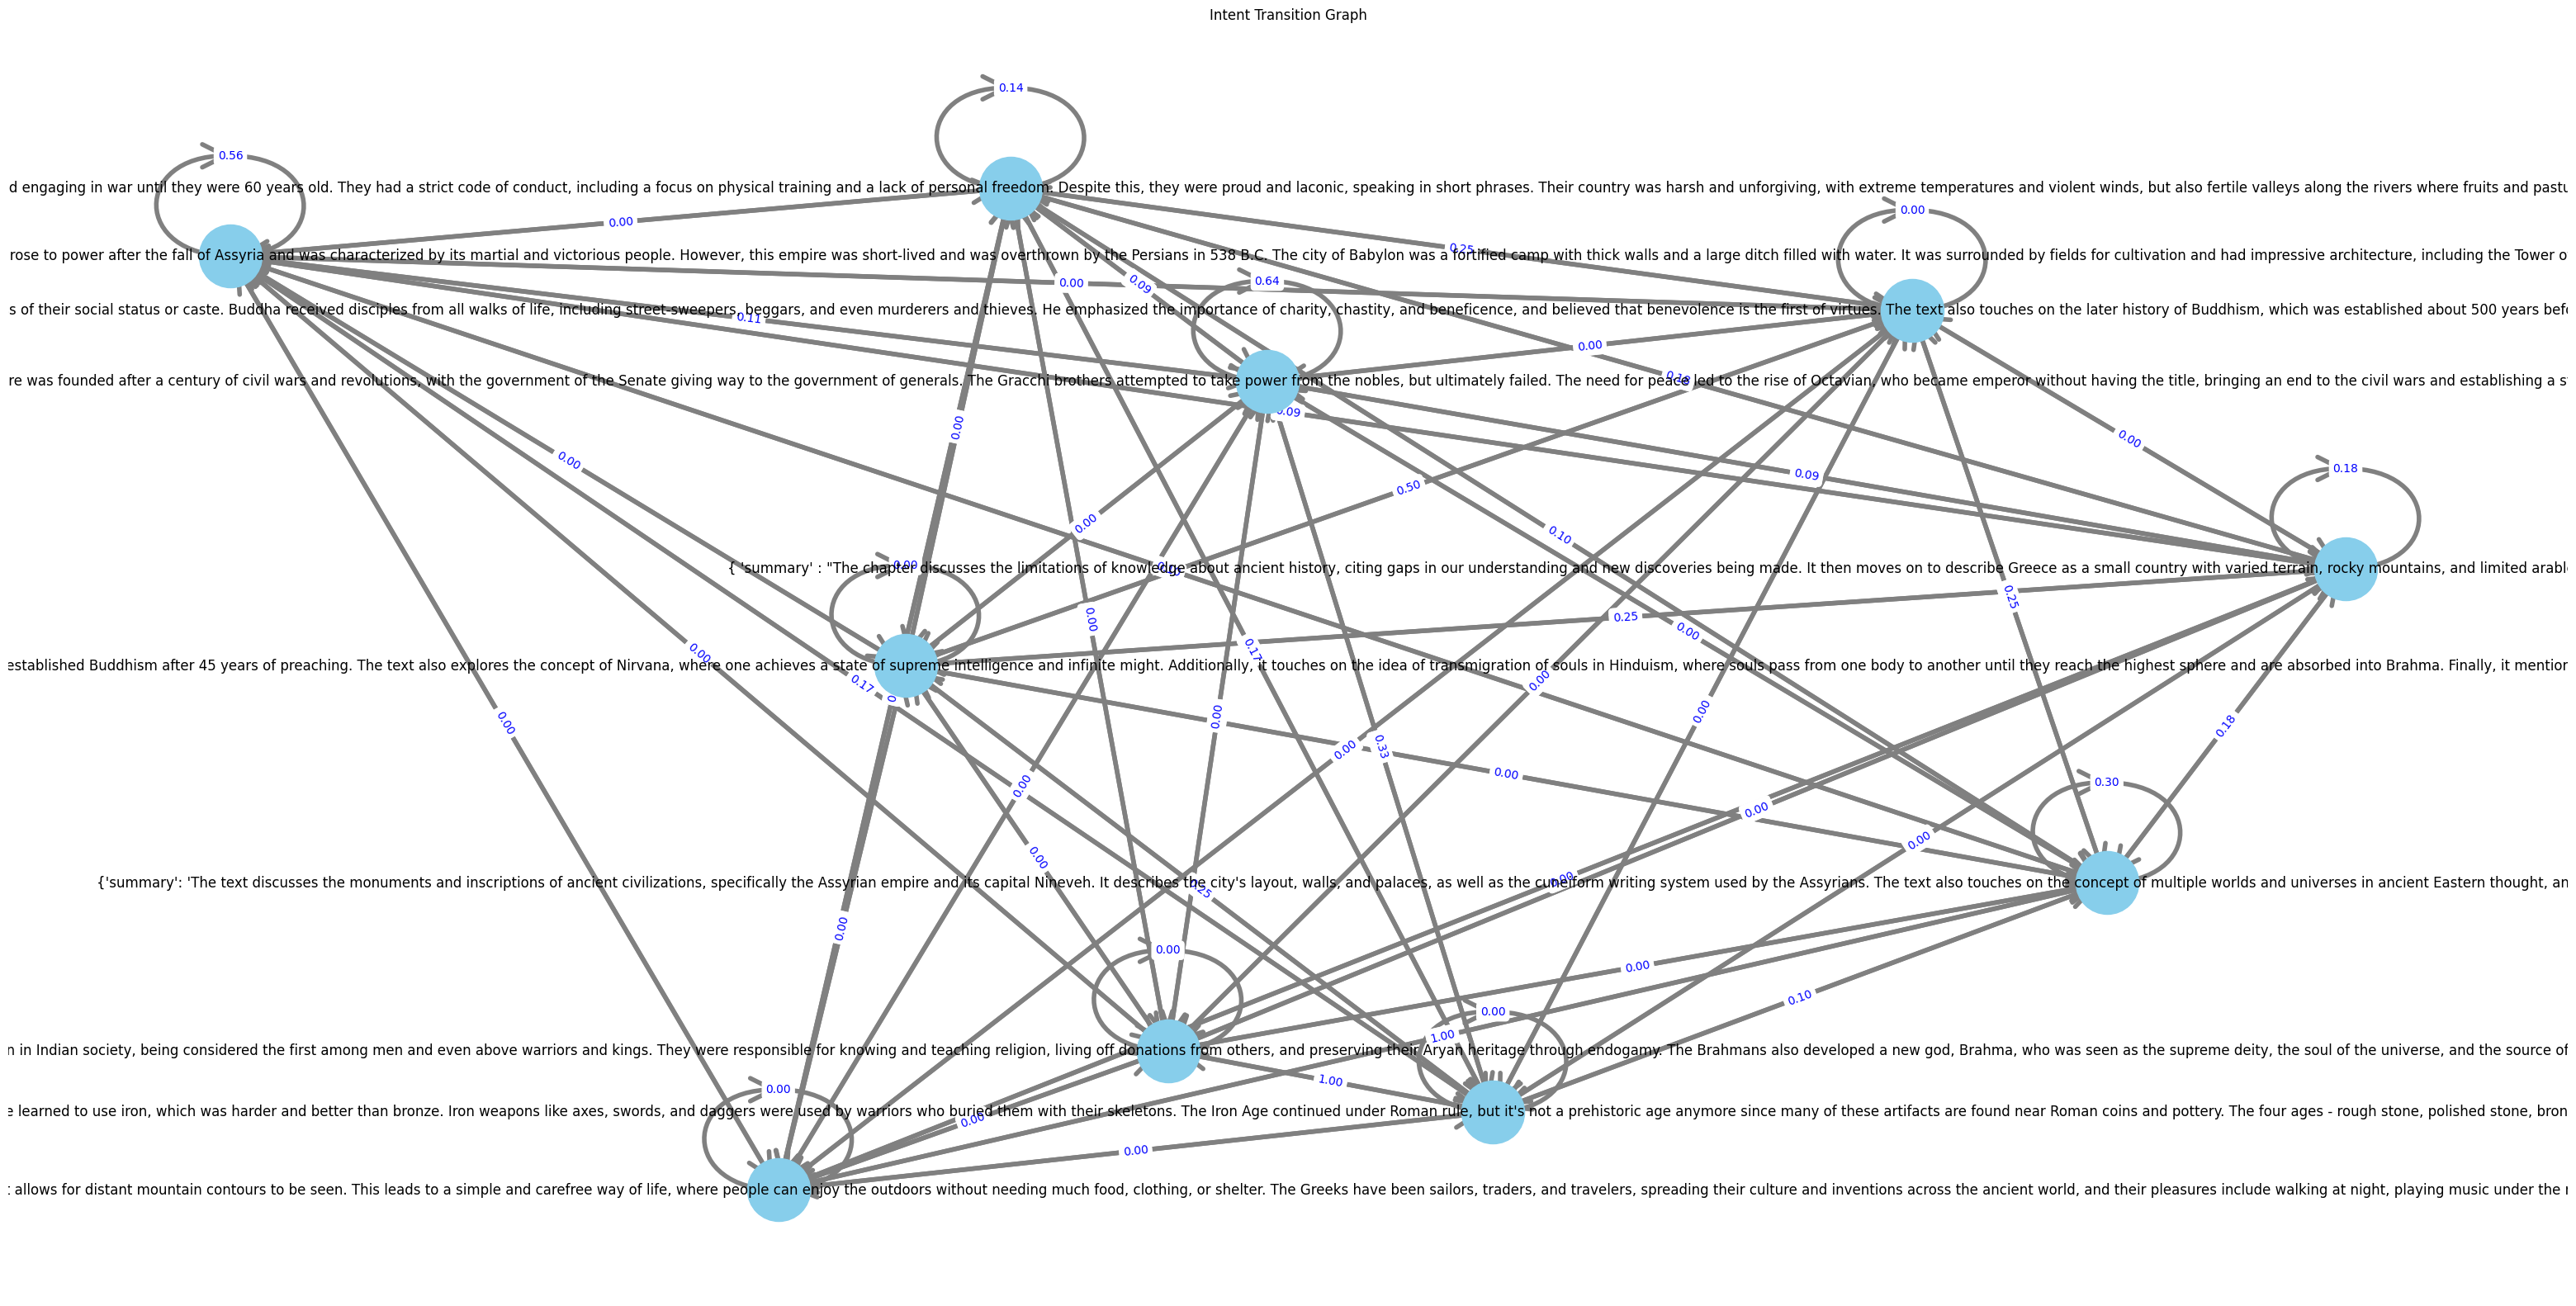

In [ ]:
plot_graph(graph  , cluster_summaries)

In [ ]:

def most_probable_path(graph, start, end):
    n = len(graph.nodes)
    
    node_to_index = {node: i for i, node in enumerate(graph.nodes)}
    index_to_node = {i: node for node, i in node_to_index.items()}
    
    dp = [[float('inf')] * n for _ in range(1 << n)]
    parent = [[-1] * n for _ in range(1 << n)]
    
    dp[1 << node_to_index[start]][node_to_index[start]] = 0
    
    for mask in range(1 << n):
        for u in range(n):
            if mask & (1 << u):
                for v in range(n):
                    if not mask & (1 << v) and graph.has_edge(index_to_node[u], index_to_node[v]):
                        new_mask = mask | (1 << v)
                        weight = graph[index_to_node[u]][index_to_node[v]].get('weight', 1)
                        if dp[mask][u] + weight < dp[new_mask][v]:
                            dp[new_mask][v] = dp[mask][u] + weight
                            parent[new_mask][v] = u
    
    full_mask = (1 << n) - 1
    u = node_to_index[end]
    min_cost = float('inf')
    end_node = -1

    for i in range(n):
        if dp[full_mask][i] < min_cost and graph.has_edge(index_to_node[i], end):
            min_cost = dp[full_mask][i]
            end_node = i

    if end_node == -1:
        return []

    path = [end]
    mask = full_mask
    u = end_node

    while u != -1:
        path.append(index_to_node[u])
        next_u = parent[mask][u]
        mask ^= (1 << u)
        u = next_u

    path.reverse()
    return path


first_node = cluster_summaries[clustered_chunks[0]["cluster"]]
last_node = cluster_summaries[clustered_chunks[len(clustered_chunks)-1]["cluster"]]
path = most_probable_path(graph , first_node , last_node)

for node in path : 
    print(node)

{'summary': 'The Iron Age began when people learned to use iron, which was harder and better than bronze. Iron weapons like axes, swords, and daggers were used by warriors who buried them with their skeletons. The Iron Age continued under Roman rule, but it's not a prehistoric age anymore since many of these artifacts are found near Roman coins and pottery. The four ages - rough stone, polished stone, bronze, and iron - don't mark periods in humanity's life, but rather epochs in the civilization of each country.'}
{'summary': 'The text describes Buddha's teachings on love, fraternity, and tolerance. He preached to his disciples that they should love even those who do them ill, and that all men are equal regardless of their social status or caste. Buddha received disciples from all walks of life, including street-sweepers, beggars, and even murderers and thieves. He emphasized the importance of charity, chastity, and beneficence, and believed that benevolence is the first of virtues. Th

In [ ]:
messages = [{'role': 'system', 'content': 'You are an advanced summarization assistant.I will provide you with several summaries of important sections of a long document. Your task is to generate a concise and comprehensive summary of the entire document based on these individual summaries.'}]

for summary in path:
    messages.append({'role': 'user', 'content': summary})

messages.append({"role" : "user" , 'content' : """Please analyze these summaries and provide an overall summary of the document. Your summary should capture the main themes, key points, and any significant details from the provided summaries.
summary : """})

overall_summary = get_completion_response(messages)


In [ ]:
print(overall_summary)

Based on the provided summaries, here is a comprehensive summary of the document:

The document explores various topics, including ancient history, philosophy, spirituality, and cultural traditions. It begins by discussing the Iron Age, which marked a significant period in human civilization, and how it was characterized by the use of iron tools and weapons.

The text then delves into Eastern spiritual traditions, specifically Buddhism, which emphasizes love, fraternity, tolerance, and charity. It also touches on the concept of Nirvana, where one achieves a state of supreme intelligence and infinite might. Additionally, it explores the idea of transmigration of souls in Hinduism, where souls pass from one body to another until they reach the highest sphere.

The document also discusses Western philosophical traditions, highlighting the lives and teachings of influential figures such as Socrates, Plato, and Aristotle. It also touches on the concept of multiple worlds and universes in an